# Hidden Markov Model with application in Regime Detection

3-15-2021

Yanhan Si

yanhans@umich.edu

- HMM with python implemention

- Application in regime detection



Introduction
-----------------------

Hidden Markov Model (HMM) is a statistical Markov model in which the system  is assumed to be a Markov process with unobservable ("hidden") states.
### Notation


-   $T$ - length of the observation sequence.
-   $N$ - number of latent (hidden) states.
-   $M$ - number of observables.
-   $Q = \{q_0, q_1, ..., q_{N-1}\}$ - hidden states.
-   $V = \{0, 1, ..., M-1\}$ - set of possible observations.
-   $\mathbf{A}$ - state transition matrix.
-   $\mathbf{B}$ - emission probability matrix.
-   $\vec{\pi}$ - initial state probability distribution.
-   $\mathcal{O} = (\mathcal{O}_0, \mathcal{O}_2, ..., \mathcal{O}_{T-1})$ -
    observation sequence.
-   $X = (x_0, x_1, ..., x_{T-1}), \ x_t \in Q$ - hidden state sequence.

Having that set defined, we can calculate the probability of any state
and observation using the matrices:

-   $\mathbf{A} = \{a_{ij}\}$ - begin an $N \times N$ transition matrix.
-   $\mathbf{B} = \{b_j(k)\}$ - being an $M \times N$ emission matrix.

The probabilities associated with transition and observation (emission)
are:

-   $a_{ij} = p( q_j^{(t + 1)} \mid q_i^{(t)} )$,
-   $b_j(k) = p(\mathcal{O}_k^{(t)} \mid q_j^{(t)})$.

The model is therefore defined as a collection:
$\lambda = (\mathbf{A}, \mathbf{B}, \vec{\pi})$.

Fundamental definitions
-----------------------

Since HMM is based on probability vectors and matrices, let's first
define objects that will represent the fundamental concepts. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class ProbabilityVector:
    def __init__(self, probabilities: dict):
        states = probabilities.keys()
        probs  = probabilities.values()
        
        assert len(states) == len(probs), "The probabilities must match the states."
        assert len(states) == len(set(states)), "The states must be unique."
        assert abs(sum(probs) - 1.0) < 1e-12, "Probabilities must sum up to 1."
        assert len(list(filter(lambda x: 0 <= x <= 1, probs))) == len(probs), \
            "Probabilities must be numbers from [0, 1] interval."
        
        self.states = sorted(probabilities)
        self.values = np.array(list(map(lambda x: 
            probabilities[x], self.states))).reshape(1, -1)
        
    @classmethod
    def initialize(cls, states: list):
        size = len(states)
        rand = np.random.rand(size) / (size**2) + 1 / size
        rand /= rand.sum(axis=0)
        return cls(dict(zip(states, rand)))
    
    @classmethod
    def from_numpy(cls, array: np.ndarray, state: list):
        return cls(dict(zip(states, list(array))))

    @property
    def dict(self):
        return {k:v for k, v in zip(self.states, list(self.values.flatten()))}

    @property
    def df(self):
        return pd.DataFrame(self.values, columns=self.states, index=['probability'])

    def __repr__(self):
        return "P({}) = {}.".format(self.states, self.values)

    def __eq__(self, other):
        if not isinstance(other, ProbabilityVector):
            raise NotImplementedError
        if (self.states == other.states) and (self.values == other.values).all():
            return True
        return False

    def __getitem__(self, state: str) -> float:
        if state not in self.states:
            raise ValueError("Requesting unknown probability state from vector.")
        index = self.states.index(state)
        return float(self.values[0, index])

    def __mul__(self, other) -> np.ndarray:
        if isinstance(other, ProbabilityVector):
            return self.values * other.values
        elif isinstance(other, (int, float)):
            return self.values * other
        else:
            NotImplementedError

    def __rmul__(self, other) -> np.ndarray:
        return self.__mul__(other)

    def __matmul__(self, other) -> np.ndarray:
        if isinstance(other, ProbabilityMatrix):
            return self.values @ other.values

    def __truediv__(self, number) -> np.ndarray:
        if not isinstance(number, (int, float)):
            raise NotImplementedError
        x = self.values
        return x / number if number != 0 else x / (number + 1e-12)

    def argmax(self):
        index = self.values.argmax()
        return self.states[index]

#### Example

In [2]:
a1 = ProbabilityVector({'rain': 0.7, 'sun': 0.3})
a2 = ProbabilityVector({'sun': 0.1, 'rain': 0.9})
print(a1.df)
print(a2.df)

print("Comparison:", a1 == a2)
print("Element-wise multiplication:", a1 * a2)
print("Argmax:", a1.argmax())
print("Getitem:", a1['rain'])

             rain  sun
probability   0.7  0.3
             rain  sun
probability   0.9  0.1
Comparison: False
Element-wise multiplication: [[0.63 0.03]]
Argmax: rain
Getitem: 0.7


### Probability Matrix

Another object is a `Probability Matrix`, which is a
core part of the HMM definition. Formally, the $\mathbf{A}$ and
$\mathbf{B}$ matrices must be *row-stochastic*, meaning that the values
of every row must sum up to 1. We can, therefore, define our PM by
stacking several PV's, which we have constructed in a way to guarantee
this constraint.


In [3]:
class ProbabilityMatrix:
    def __init__(self, prob_vec_dict: dict):
        
        assert len(prob_vec_dict) > 1, \
            "The numebr of input probability vector must be greater than one."
        assert len(set([str(x.states) for x in prob_vec_dict.values()])) == 1, \
            "All internal states of all the vectors must be indentical."
        assert len(prob_vec_dict.keys()) == len(set(prob_vec_dict.keys())), \
            "All observables must be unique."

        self.states      = sorted(prob_vec_dict)
        self.observables = prob_vec_dict[self.states[0]].states
        self.values      = np.stack([prob_vec_dict[x].values for x in self.states]).squeeze() 

    @classmethod
    def initialize(cls, states: list, observables: list):
        size = len(states)
        rand = np.random.rand(size, len(observables)) / (size**2) + 1 / size
        rand /= rand.sum(axis=1).reshape(-1, 1)
        aggr = [dict(zip(observables, rand[i, :])) for i in range(len(states))]
        pvec = [ProbabilityVector(x) for x in aggr]
        return cls(dict(zip(states, pvec)))

    @classmethod
    def from_numpy(cls, array: np.ndarray, states: list, observables: list):
        p_vecs = [ProbabilityVector(dict(zip(observables, x))) for x in array]
        return cls(dict(zip(states, p_vecs)))

    @property
    def dict(self):
        return self.df.to_dict()

    @property
    def df(self):
        return pd.DataFrame(self.values, columns=self.observables, index=self.states)

    def __repr__(self):
        return "PM {} states: {} -> obs: {}.".format(
            self.values.shape, self.states, self.observables)

    def __getitem__(self, observable: str) -> np.ndarray:
        if observable not in self.observables:
            raise ValueError("Requesting unknown probability observable from the matrix.")
        index = self.observables.index(observable)
        return self.values[:, index].reshape(-1, 1)

Here, the way we instantiate PM's is by supplying a dictionary of PV's
to the constructor of the class. By doing this, we not only ensure that
every row of PM is stochastic, but also supply the names for every
**observable**. Our PM can, therefore, give an array of coefficients for any observable.


Mathematically, the PM is a $(M \times N)$ matrix:

$$% <![CDATA[
\text{PM} = 
 \begin{bmatrix}
  c_{1,1} & c_{1,2} & \cdots & c_{1,N} \\
  c_{2,1} & c_{2,2} & \cdots & c_{2,N} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  c_{M,1} & c_{M,2} & \cdots & c_{M,N} 
 \end{bmatrix}
=
 \begin{bmatrix}
 (p_0, p_1, ..., p_{N_- 1})_1 \\
 (p_0, p_1, ..., p_{N - 1})_2 \\
 \vdots \\
 (p_0, p_1, ..., p_{N - 1})_M
 \end{bmatrix} %]]>$$

The other methods are implemented in similar way to PV.

#### Example 

In [4]:
a1 = ProbabilityVector({'rain': 0.7, 'sun': 0.3})
a2 = ProbabilityVector({'rain': 0.6, 'sun': 0.4})
A  = ProbabilityMatrix({'hot': a1, 'cold': a2})

print(A)
print(A.df)

PM (2, 2) states: ['cold', 'hot'] -> obs: ['rain', 'sun'].
      rain  sun
cold   0.6  0.4
hot    0.7  0.3


In [5]:
b1 = ProbabilityVector({'0S': 0.1, '1M': 0.4, '2L': 0.5})
b2 = ProbabilityVector({'0S': 0.7, '1M': 0.2, '2L': 0.1})
B =  ProbabilityMatrix({'0H': b1, '1C': b2})

print(B)
print(B.df)

PM (2, 3) states: ['0H', '1C'] -> obs: ['0S', '1M', '2L'].
     0S   1M   2L
0H  0.1  0.4  0.5
1C  0.7  0.2  0.1


In [6]:
B["0S"]

array([[0.1],
       [0.7]])

Implementing Hidden Markov Chain
--------------------------------


### Computing score

Computing the score means to find what is the probability of a
particular chain of observations $\mathcal{O}$ given our (known) model
$\lambda = (\mathbf{A}, \mathbf{B}, \vec{\pi})$. In other words, we are
interested in finding $p(\mathcal{O}\mid\lambda)$.

We can find $p(\mathcal{O}\mid\lambda)$ by *marginalizing* all possible
chains of the hidden variables $X$, where $X = \{x_0,x_1,...x_{T-1}\}$:

$$p(\mathcal{O}\mid\lambda) = \sum_X p(\mathcal{O},X|\lambda) = \sum_X p(\mathcal{O}|X,\lambda)p(X|\lambda)$$

Since
$p(\mathcal{O}\mid X,\lambda) = \prod_{t=0}^{T-1} b_{x_t}(\mathcal{O}_t)$
(the product of all probabilities related to the observables) and
$p(X\mid\lambda) = \vec{\pi} \prod_{t=0}^{T-1} a_{x_{t+1},x_{t}}$ (the
product of all probabilities of transitioning from $x_{t}$ to $x_{t+1}$,
the probability we are looking for (the **score**) is:

$$p(\mathcal{O}|\lambda) = \sum_X \vec{\pi} b_{x_0}(\mathcal{O}_0)a_{x_0,x_1}b_{x_1}(
\mathcal{O}_1)a_{x_1,x_2}...b_{x_{T-1}}(\mathcal{O}_{T-1})a_{T-1,T-2} \\
= \sum_X \vec{\pi} \prod_{t=0}^{T-1} a_{x_t,x_{t-1}}b_{x_{t}}(\mathcal{O}_t)$$



In [7]:
from itertools import product
from functools import reduce


class HiddenMarkovChain:
    def __init__(self, T, E, pi):
        self.T = T  # transmission matrix A
        self.E = E  # emission matrix B
        self.pi = pi
        self.states = pi.states
        self.observables = E.observables
    
    def __repr__(self):
        return "HML states: {} -> observables: {}.".format(
            len(self.states), len(self.observables))
    
    @classmethod
    def initialize(cls, states: list, observables: list):
        T = ProbabilityMatrix.initialize(states, states)
        E = ProbabilityMatrix.initialize(states, observables)
        pi = ProbabilityVector.initialize(states)
        return cls(T, E, pi)
    
    def _create_all_chains(self, chain_length):
        return list(product(*(self.states,) * chain_length))
    
    def score(self, observations: list) -> float:
        def mul(x, y): return x * y
        
        score = 0
        all_chains = self._create_all_chains(len(observations))
        for idx, chain in enumerate(all_chains):
            expanded_chain = list(zip(chain, [self.T.states[0]] + list(chain)))
            expanded_obser = list(zip(observations, chain))
            
            p_observations = list(map(lambda x: self.E.df.loc[x[1], x[0]], expanded_obser))
            p_hidden_state = list(map(lambda x: self.T.df.loc[x[1], x[0]], expanded_chain))
            p_hidden_state[0] = self.pi[chain[0]]
            
            score += reduce(mul, p_observations) * reduce(mul, p_hidden_state)
        return score

#### Example

In [8]:
a1 = ProbabilityVector({'1H': 0.7, '2C': 0.3})
a2 = ProbabilityVector({'1H': 0.4, '2C': 0.6})

b1 = ProbabilityVector({'1S': 0.1, '2M': 0.4, '3L': 0.5})
b2 = ProbabilityVector({'1S': 0.7, '2M': 0.2, '3L': 0.1})

A = ProbabilityMatrix({'1H': a1, '2C': a2})
B = ProbabilityMatrix({'1H': b1, '2C': b2})
pi = ProbabilityVector({'1H': 0.6, '2C': 0.4})

hmc = HiddenMarkovChain(A, B, pi)
observations = ['1S', '2M', '3L', '2M', '1S']
print("Transition matrix")
print(A.df)
print()
print("Emission matrix")
print(B.df)
print()
print("Initial state probability distribution")
print(pi)
print()
print("Score for {} is {:f}.".format(observations, hmc.score(observations)))

Transition matrix
     1H   2C
1H  0.7  0.3
2C  0.4  0.6

Emission matrix
     1S   2M   3L
1H  0.1  0.4  0.5
2C  0.7  0.2  0.1

Initial state probability distribution
P(['1H', '2C']) = [[0.6 0.4]].

Score for ['1S', '2M', '3L', '2M', '1S'] is 0.003482.


If our implementation is correct, then all score values for all possible
observation chains, for a given model $\lambda$ should add up to one.


$$\sum_{\mathcal{O}} p(\mathcal{O}|\lambda) = 1$$


In [9]:
all_possible_observations = {'1S', '2M', '3L'}
chain_length = 3  # any int > 0
all_observation_chains = list(product(*(all_possible_observations,) * chain_length))
all_possible_scores = list(map(lambda obs: hmc.score(obs), all_observation_chains))
print("All possible scores added: {}.".format(sum(all_possible_scores)))

All possible scores added: 0.9999999999999998.


### Score with forward-pass


Another way to do it is to calculate *partial observations of a sequence
up to time* $t$.

For $i \in \{0, 1, ..., N-1\}$ and $t \in \{0, 1, ..., T-1\}$:

$$\alpha_t(i) = p(\mathcal{O}_0, \mathcal{O}_1, ..., \mathcal{O}_t, x_t = q_i|\lambda)$$

Consequently,

$$\alpha_0(i) = \vec{\pi} b_i(\mathcal{O}_0) \quad \text{for} \quad i = 0, 1, ..., N-1$$

and

$$\alpha_t(i) = \left[\sum_{j=0}^{N-1} \alpha_{t-1}(j) a_{j,i}\right] b_i(\mathcal{O_t})$$

Then

$$p(\mathcal{O}|\lambda) = \sum_{i=0}^{N-1} \alpha_{T-1}(i)$$

Note that $\alpha_t$ is a vector of lenght $N$. The sum of the product
$\alpha_{t-1}(j)a_{j,i}$ can, in fact, be written as a dot product.
Therefore:

$$\left[\sum_{j=0}^{N-1} \alpha_{t-1}(j)a_{j,i}\right] b_i(\mathcal{O}_t) = [\vec{\alpha}_{t-1} \cdot \mathbf{A}] \star \vec{b}^T(\mathcal{O}_t) \to \vec{\alpha}_t$$

where by $\star$ we denote an element-wise multiplication.

With this implementation, we reduce the number of multiplication to
$N^2T$ and can take advantage of vectorization.

In [10]:
class HiddenMarkovChain_FP(HiddenMarkovChain):
    def _alphas(self, observations: list) -> np.ndarray:
        alphas = np.zeros((len(observations), len(self.states)))
        alphas[0, :] = self.pi.values * self.E[observations[0]].T
        for t in range(1, len(observations)):
            alphas[t, :] = (alphas[t - 1, :].reshape(1, -1) 
                         @ self.T.values) * self.E[observations[t]].T
        return alphas
    
    def score(self, observations: list) -> float:
        alphas = self._alphas(observations)
        return float(alphas[-1].sum())

#### Example

In [11]:
hmc_fp = HiddenMarkovChain_FP(A, B, pi)

observations = ['1S', '2M', '3L', '2M', '1S']
print("Score for {} is {:f}.".format(observations, hmc_fp.score(observations)))

Score for ['1S', '2M', '3L', '2M', '1S'] is 0.003482.


### Simulation and convergence

Basically, let's take our
$\lambda = (\mathbf{A}, \mathbf{B}, \vec{\pi})$ and use it to generate a
sequence of random observables, starting from some initial state
probability $\vec{\pi}$.

In [12]:
class HiddenMarkovChain_Simulation(HiddenMarkovChain):
    def run(self, length: int) -> (list, list):
        assert length >= 0, "The chain needs to be a non-negative number."
        s_history = [0] * (length + 1)
        o_history = [0] * (length + 1)
        
        prb = self.pi.values
        obs = prb @ self.E.values
        s_history[0] = np.random.choice(self.states, p=prb.flatten())
        o_history[0] = np.random.choice(self.observables, p=obs.flatten())
        
        for t in range(1, length + 1):
            prb = prb @ self.T.values
            obs = prb @ self.E.values
            s_history[t] = np.random.choice(self.states, p=prb.flatten())
            o_history[t] = np.random.choice(self.observables, p=obs.flatten())
        
        return o_history, s_history

#### Example

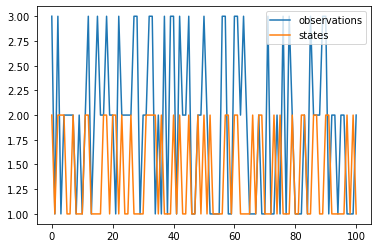

In [13]:
hmc_s = HiddenMarkovChain_Simulation(A, B, pi)
observation_hist, states_hist = hmc_s.run(100)  # length = 100
stats = pd.DataFrame({
    'observations': observation_hist,
    'states': states_hist}).applymap(lambda x: int(x[0])).plot()


If the desired length $T$ is "large enough", we would expect that the
system to converge on a sequence that, on average, gives the same number
of events as we would expect from $\mathbf{A}$ and $\mathbf{B}$ matrices
directly. In other words, the transition and the emission matrices
"decide", with a certain probability, what the next state will be and
what observation we will get, for every step, respectively. Therefore,
what may initially look like random events, on average should reflect
the coefficients of the matrices themselves. Let's check that as well.

### Latent states

The state matrix $\mathbf{A}$ is given by the following coefficients:

$$p(q_{t+1}=\textsf{1H})|q_t=\textsf{1H}) = 0.7$$
$$p(q_{t+1}=\textsf{1H})|q_t=\textsf{2C}) = 0.4$$
$$p(q_{t+1}=\textsf{2C})|q_t=\textsf{1H}) = 0.3$$ $$p
(q_{t+1}=\textsf{2C})|q_t=\textsf{2C}) = 0.6$$

Consequently, the probability of "being" in the state $\textsf{1H}$ at
$t + 1$, regardless of the previous state, is equal to:

$$p(\textsf{1H}) = p(\textsf{1H}\mid\textsf{1H})p(\textsf{1H}) + p(\textsf{1H}\mid\textsf{2C})p(\textsf{2C})$$

If we assume that the *prior* probabilities of being at some state at
$t$ are totally random, then $p(\textsf{1H}) = 1$ and
$p(\textsf{2C}) = 0.9$, which after renormalizing give 0.55 and 0.45,
respectively.

If we count the number of occurences of each state and divide it by the
number of elements in our sequence, we would get closer and closer to
these number as the lenght of the sequence grows.

#### Example

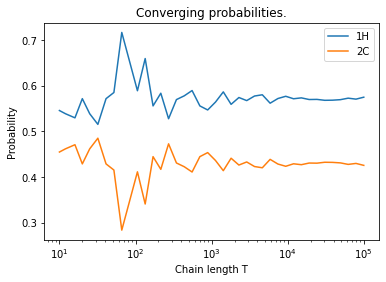

In [14]:
hmc_s = HiddenMarkovChain_Simulation(A, B, pi)

stats = {}
for length in np.logspace(1, 5, 40).astype(int):
    observation_hist, states_hist = hmc_s.run(length)
    stats[length] = pd.DataFrame({
        'observations': observation_hist,
        'states': states_hist}).applymap(lambda x: int(x[0]))

S = np.array(list(map(lambda x: 
        x['states'].value_counts().to_numpy() / len(x), stats.values())))

plt.semilogx(np.logspace(1, 5, 40).astype(int), S)
plt.xlabel('Chain length T')
plt.ylabel('Probability')
plt.title('Converging probabilities.')
plt.legend(['1H', '2C'])
plt.show()

Uncovering hidden variables
---------------------------

Let's take our `HiddenMarkovChain` class to the next
level and supplement it with more methods. The methods will help us to
discover the most probable sequence of hidden variables behind the
observation sequence.

### Expanding the class

We have defined $\vec{\alpha}$ to be the probability of partial
observation of the sequence up to time $t$.

$$\vec{\alpha}_t = [\vec{\alpha}_{t-1} \cdot \mathbf{A}] \star (\vec{b})^T(\mathcal{O}_t)$$

Now, let's define the "opposite" probability. Namely, the probability of
observing the sequence from $T-1$ down to $t$.

For $t = 0, 1, ..., T-1$ and $i = 0, 1, ..., N-1$, we define:

$$\beta_t(i) = p(\mathcal{O}_{t+1}, \mathcal{O}_{t+2}, ..., \mathcal{O}_{T-1}|x_t = q_i, \lambda)$$

As before, we can calulate $\beta_t(i)$ recursively:

$$\beta_{T-1}(i) = 1 \quad \text{for} \quad i = 0, 1, ..., N-1$$

Then for $t \ne T-1$:

$$\beta_t(i) = \sum_{j=0}^{N-1} a_{i,j}b_j(\mathcal{O}_{t+1})\beta_{t+1}(j)$$

which in vectorized form, will be:

$$\vec{\beta}_t = [\mathbf{A} \cdot \vec{b}(\mathcal{O}_{t+1})] \star \vec{\beta}_{t+1}$$

Finally, we also define a new quantity $\gamma$ to indicate the state
$q_i$ at time $t$, for which the probability (calculated forwards and
backwards) is the maximum:

$$\gamma_t(i) = \frac{\alpha_t(i)\beta_t(i)}{p(\mathcal{O}|\lambda)}$$

Consequently, for any step $t = 0, 1, ..., T-1$, the state of the
maximum likelihood can be found using:

$$q_i^{(t)} = \arg \max_i (\vec{\alpha}_t \star \vec{\beta}_t)$$

In [15]:
class HiddenMarkovChain_Uncover(HiddenMarkovChain_Simulation):
    def _alphas(self, observations: list) -> np.ndarray:
        alphas = np.zeros((len(observations), len(self.states)))
        alphas[0, :] = self.pi.values * self.E[observations[0]].T
        for t in range(1, len(observations)):
            alphas[t, :] = (alphas[t - 1, :].reshape(1, -1) @ self.T.values) \
                         * self.E[observations[t]].T
        return alphas
    
    def _betas(self, observations: list) -> np.ndarray:
        betas = np.zeros((len(observations), len(self.states)))
        betas[-1, :] = 1
        for t in range(len(observations) - 2, -1, -1):
            betas[t, :] = (self.T.values @ (self.E[observations[t + 1]] \
                        * betas[t + 1, :].reshape(-1, 1))).reshape(1, -1)
        return betas
    
    def uncover(self, observations: list) -> list:
        alphas = self._alphas(observations)
        betas = self._betas(observations)
        maxargs = (alphas * betas).argmax(axis=1)
        return list(map(lambda x: self.states[x], maxargs))

### Validation

To validate, let's generate some observable sequence $\mathcal{O}$. For
that, we can use our model's `.run` method. Then, we
will use the `.uncover` method to find the most
likely latent variable sequence.

#### Example

In [16]:
np.random.seed(42)

a1 = ProbabilityVector({'1H': 0.7, '2C': 0.3})
a2 = ProbabilityVector({'1H': 0.4, '2C': 0.6})
b1 = ProbabilityVector({'1S': 0.1, '2M': 0.4, '3L': 0.5}) 
b2 = ProbabilityVector({'1S': 0.7, '2M': 0.2, '3L': 0.1})
A  = ProbabilityMatrix({'1H': a1, '2C': a2})
B  = ProbabilityMatrix({'1H': b1, '2C': b2})
pi = ProbabilityVector({'1H': 0.6, '2C': 0.4})

hmc = HiddenMarkovChain_Uncover(A, B, pi)

observed_sequence, latent_sequence = hmc.run(5)
uncovered_sequence = hmc.uncover(observed_sequence)

In [17]:
print("Transition matrix")
print(A.df)
print()
print("Emission matrix")
print(B.df)
print()
print("Initial state probability distribution")
print(pi)


Transition matrix
     1H   2C
1H  0.7  0.3
2C  0.4  0.6

Emission matrix
     1S   2M   3L
1H  0.1  0.4  0.5
2C  0.7  0.2  0.1

Initial state probability distribution
P(['1H', '2C']) = [[0.6 0.4]].


In [18]:
print(observed_sequence)
print(latent_sequence)
print(uncovered_sequence)

['3L', '2M', '1S', '3L', '3L', '3L']
['1H', '2C', '1H', '1H', '2C', '1H']
['1H', '1H', '2C', '1H', '1H', '1H']




The code below, evaluates the likelihood of different latent sequences resulting in our observation sequence.

In [19]:
all_possible_states = {'1H', '2C'}
chain_length = 6  # any int > 0
all_states_chains = list(product(*(all_possible_states,) * chain_length))

df = pd.DataFrame(all_states_chains)
dfp = pd.DataFrame()

for i in range(chain_length):
    dfp['p' + str(i)] = df.apply(lambda x: 
        hmc.E.df.loc[x[i], observed_sequence[i]], axis=1)

scores = dfp.sum(axis=1).sort_values(ascending=False)
df = df.iloc[scores.index]
df['score'] = scores
df.head(10).reset_index()

,index,0,1,2,3,4,5,score
0,55,1H,1H,2C,1H,1H,1H,3.1
1,39,1H,2C,2C,1H,1H,1H,2.9
2,23,2C,1H,2C,1H,1H,1H,2.7
3,53,1H,1H,2C,1H,2C,1H,2.7
4,54,1H,1H,2C,1H,1H,2C,2.7
5,51,1H,1H,2C,2C,1H,1H,2.7
6,63,1H,1H,1H,1H,1H,1H,2.5
7,7,2C,2C,2C,1H,1H,1H,2.5
8,37,1H,2C,2C,1H,2C,1H,2.5
9,35,1H,2C,2C,2C,1H,1H,2.5


In [20]:
dfc = df.copy().reset_index()
for i in range(chain_length):
    dfc = dfc[dfc[i] == latent_sequence[i]]
    
dfc

,index,0,1,2,3,4,5,score
34,45,1H,2C,1H,1H,2C,1H,1.9


Training the model
------------------

The time has come to show the training procedure. Formally, we are
interested in finding $\lambda = (\mathbf{A}, \mathbf{B}, \vec{\pi})$
such that given a desired observation sequence $\mathcal{O}$, our model
$\lambda$ would give the best fit.

### Expanding the class 

Here, our starting point will be the
`HiddenMarkovModel_Uncover` that we have defined
earlier. We will add new methods to train it.

Knowing our latent states $Q$ and possible observation states
$\mathcal{O}$, we automatically know the sizes of the matrices
$\mathbf{A}$ and $\mathbf{B}$, hence $N$ and $M$. However, we need to
determine $\{a_{i,j}\}, \{b_j(k)\}$ and $\vec{\pi}$.

For $t = 0, 1, ..., T - 2$ and $i, j \in \{0, 1, ..., N - 1\}$, we
define "di-gammas":

$$\gamma_t(i, j) = p(x_t = q_i, x_{t + 1} = q_j \ | \ \mathcal{O}, \lambda)$$

$\gamma_t(i, j)$ is the probability of transitioning
$q_t \to q_{t + 1}$. Writing it in terms of $\alpha, \beta, A, B$, we
have:

$$\gamma_t(i, j) = \frac{\alpha_t(i)a_{i, j}b_j(\mathcal{O}_{t + 1})\beta_{t + 1}(j)}{p(\mathcal{O}|\gamma)}$$

Now, thinking in terms of implementation, we want to avoid looping over
$i, j$ and $t$ at the same time, as it's gonna be deadly slow.
Fortunately, for every $t$, we can vectorize the equation (preserving
that $\alpha, a$ are indexed with i$t$ while $\beta, b$ are indexed with
$t + 1$).

$$\mathbf{\gamma}_t = \frac{
\vec{\alpha}_t \star \mathbf{A}^T \star \vec{b}(\mathcal{O}_{t + 1})^T \star \vec{\beta}_t
}{p(\mathcal{O}|\lambda)}$$

Having the equation for $\gamma_t(i, j)$, we can calulate

$$\vec{\gamma}_t(i) = \sum_{j = 0}^{N - 1} \gamma_t(i, j)$$

To find $\lambda = (\mathbf{A}, \mathbf{B}, \vec{\pi})$, we do

-   For $i = 0, 1, ..., N - 1$:

$$\pi_i = \gamma_{t = 0}(i)$$

or

$$\vec{\pi} = \vec{\gamma}_{t = 0}$$

-   For $i, j = 0, 1, ..., N - 1$:

$$a_{i, j} = \frac{\sum_{t = 0}^{T - 2}\gamma_t(i, j)}{\sum_{t = 0}^{T - 2}\gamma_t(i)}$$

-   For $j = 0, 1, ..., N - 1$ and $k = 0, 1, ..., M - 1$:

$$b_j(k) = \frac{\sum_{t = 0}^{T - 1} \sum_{\mathcal{O}_t = k} \gamma_t(j)}{ \sum_{t = 0}^{T - 1}\gamma_t(j)}$$

In [21]:
class HiddenMarkovLayer(HiddenMarkovChain_Uncover):
    def _digammas(self, observations: list) -> np.ndarray:
        L, N = len(observations), len(self.states)
        digammas = np.zeros((L - 1, N, N))

        alphas = self._alphas(observations)
        betas = self._betas(observations)
        score = self.score(observations)
        for t in range(L - 1):
            P1 = (alphas[t, :].reshape(-1, 1) * self.T.values)
            P2 = self.E[observations[t + 1]].T * betas[t + 1].reshape(1, -1)
            digammas[t, :, :] = P1 * P2 / score
        return digammas  

Having the "layer" supplemented with the
`._digammas` method, we should be able to perform
all the necessary calculations. However, it makes sense to delegate the
"management" of the layer to another class. In fact, the model training
can be summarized as follows:

1.  Initialize $\mathbf{A}, \mathbf{B}$ and $\vec{\pi}$.
2.  Calculate $\gamma_t(i, j)$.
3.  Update the model's $\mathbf{A}, \mathbf{B}$ and $\vec{\pi}$.
4.  We repeat the 2. and 3. until the score $p(\mathcal{O}\mid\lambda)$
    no longer increases.


In [22]:
class HiddenMarkovModel:
    def __init__(self, hml: HiddenMarkovLayer):
        self.layer = hml
        self._score_init = 0
        self.score_history = []

    @classmethod
    def initialize(cls, states: list, observables: list):
        layer = HiddenMarkovLayer.initialize(states, observables)
        return cls(layer)

    def update(self, observations: list) -> float:
        alpha = self.layer._alphas(observations)
        beta = self.layer._betas(observations)
        digamma = self.layer._digammas(observations)
        score = alpha[-1].sum()
        gamma = alpha * beta / score 

        L = len(alpha)
        obs_idx = [self.layer.observables.index(x) for x in observations]
        capture = np.zeros((L, len(self.layer.states), len(self.layer.observables)))
        for t in range(L):
            capture[t, :, obs_idx[t]] = 1.0

        pi = gamma[0]
        T = digamma.sum(axis=0) / gamma[:-1].sum(axis=0).reshape(-1, 1)
        E = (capture * gamma[:, :, np.newaxis]).sum(axis=0) / gamma.sum(axis=0).reshape(-1, 1)

        self.layer.pi = ProbabilityVector.from_numpy(pi, self.layer.states)
        self.layer.T = ProbabilityMatrix.from_numpy(T, self.layer.states, self.layer.states)
        self.layer.E = ProbabilityMatrix.from_numpy(E, self.layer.states, self.layer.observables)
            
        return score

    def train(self, observations: list, epochs: int, tol=None):
        self._score_init = 0
        self.score_history = (epochs + 1) * [0]
        early_stopping = isinstance(tol, (int, float))

        for epoch in range(1, epochs + 1):
            score = self.update(observations)
            print("Training... epoch = {} out of {}, score = {}.".format(epoch, epochs, score))
            if early_stopping and abs(self._score_init - score) / score < tol:
                print("Early stopping.")
                break
            self._score_init = score
            self.score_history[epoch] = score

#### Example

In [23]:
np.random.seed(42)

observations = ['3L', '2M', '1S', '3L', '3L', '3L']

states = ['1H', '2C']
observables = ['1S', '2M', '3L']

hml = HiddenMarkovLayer.initialize(states, observables)
hmm = HiddenMarkovModel(hml)

hmm.train(observations, 25)

Training... epoch = 1 out of 25, score = 0.0013006714785001687.
Training... epoch = 2 out of 25, score = 0.005509420540117939.
Training... epoch = 3 out of 25, score = 0.0055308588828216765.
Training... epoch = 4 out of 25, score = 0.005567116674468164.
Training... epoch = 5 out of 25, score = 0.005630618250468596.
Training... epoch = 6 out of 25, score = 0.005741158382934694.
Training... epoch = 7 out of 25, score = 0.0059280441106285.
Training... epoch = 8 out of 25, score = 0.006225866084209211.
Training... epoch = 9 out of 25, score = 0.006652847604517519.
Training... epoch = 10 out of 25, score = 0.00717178787364083.
Training... epoch = 11 out of 25, score = 0.007683641981602112.
Training... epoch = 12 out of 25, score = 0.00810084555475405.
Training... epoch = 13 out of 25, score = 0.008410987791562219.
Training... epoch = 14 out of 25, score = 0.00865079504603925.
Training... epoch = 15 out of 25, score = 0.008861021470118063.
Training... epoch = 16 out of 25, score = 0.00907509

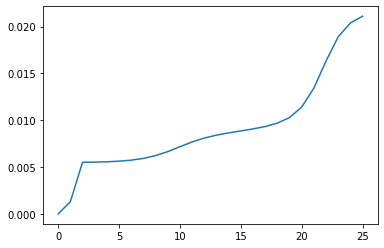

In [24]:
plt.plot(np.arange(0,len(hmm.score_history)), hmm.score_history)

### Verification

Let's look at the generated sequences. The "demanded" sequence is:

      0    1    2    3    4    5
  --- ---- ---- ---- ---- ---- ----
    0 3L   2M   1S   3L   3L   3L

In [25]:
RUNS = 100000
T = 5

chains = RUNS * [0]
for i in range(len(chains)):
    chain = hmm.layer.run(T)[0]
    chains[i] = '-'.join(chain)

The table below summarizes simulated runs based on 100000 attempts (see above), with the frequency of occurrence and number of matching observations.

The bottom line is that if we have truly trained the model, we should see a strong tendency for it to generate us sequences that resemble the one we require. Let’s see if it happens.

In [26]:
df = pd.DataFrame(pd.Series(chains).value_counts(), columns=['counts']).reset_index().rename(columns={'index': 'chain'})
df = pd.merge(df, df['chain'].str.split('-', expand=True), left_index=True, right_index=True)

s = []
for i in range(T + 1):
    s.append(df.apply(lambda x: x[i] == observations[i], axis=1))

df['matched'] = pd.concat(s, axis=1).sum(axis=1)
df['counts'] = df['counts'] / RUNS * 100
df = df.drop(columns=['chain'])
df.head(30)

,counts,0,1,2,3,4,5,matched
0,8.907,3L,3L,3L,3L,3L,3L,4
1,4.422,3L,2M,3L,3L,3L,3L,5
2,4.286,1S,3L,3L,3L,3L,3L,3
3,4.284,3L,3L,3L,3L,3L,2M,3
4,4.278,3L,3L,3L,2M,3L,3L,3
5,4.227,3L,3L,1S,3L,3L,3L,5
6,4.179,3L,3L,3L,3L,1S,3L,3
7,2.179,3L,2M,3L,2M,3L,3L,4
8,2.173,3L,2M,3L,3L,1S,3L,4
9,2.165,1S,3L,1S,3L,3L,3L,4


As we can see, there is a tendency for our model to generate sequences that resemble the one we require, although the exact one (the one that matchs 6/6) places itself already at the 13th position! On the other hand, according to the table, the top 10 sequencies are still the ones that are somewhat similar to the one we request.

To ultimately verify the quality of our model, let’s plot the outcomes together with the frequency of occrence and compare it agains a freshly initialized model, which is supposed to give us completely random sequences - just to compare.

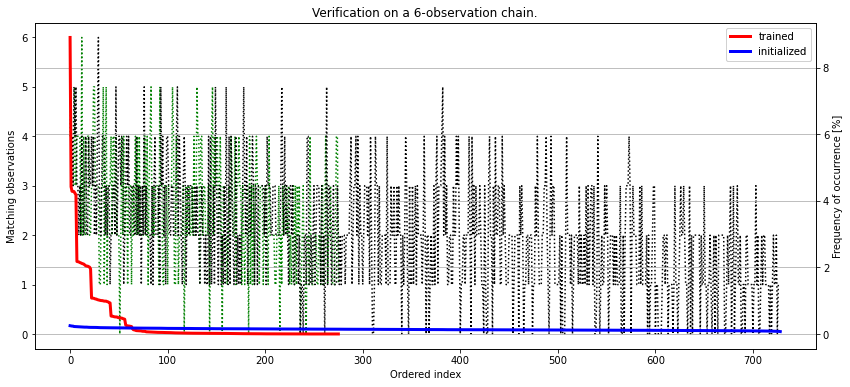

In [27]:
hml_rand = HiddenMarkovLayer.initialize(states, observables)
hmm_rand = HiddenMarkovModel(hml_rand)

RUNS = 100000
T = 5

chains_rand = RUNS * [0]
for i in range(len(chains_rand)):
    chain_rand = hmm_rand.layer.run(T)[0]
    chains_rand[i] = '-'.join(chain_rand)

df2 = pd.DataFrame(pd.Series(chains_rand).value_counts(), columns=['counts']).reset_index().rename(columns={'index': 'chain'})
df2 = pd.merge(df2, df2['chain'].str.split('-', expand=True), left_index=True, right_index=True)

s = []
for i in range(T + 1):
    s.append(df2.apply(lambda x: x[i] == observations[i], axis=1))

df2['matched'] = pd.concat(s, axis=1).sum(axis=1)
df2['counts'] = df2['counts'] / RUNS * 100
df2 = df2.drop(columns=['chain'])

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(df['matched'], 'g:')
ax.plot(df2['matched'], 'k:')

ax.set_xlabel('Ordered index')
ax.set_ylabel('Matching observations')
ax.set_title('Verification on a 6-observation chain.')

ax2 = ax.twinx()
ax2.plot(df['counts'], 'r', lw=3)
ax2.plot(df2['counts'], 'b', lw=3)
ax2.set_ylabel('Frequency of occurrence [%]')

ax.legend(['trained', 'initialized'])
ax2.legend(['trained', 'initialized'])

plt.grid()
plt.show()



Summary
----------

In this notebook, we have presented a step-by-step implementation of the
Hidden Markov Model. We have created the code by adapting the first
principles approach. More specifically, we have shown how the
probabilistic concepts that are expressed through equations can be
implemented as objects and methods. Finally, we demonstrated the usage
of the model with finding the score, uncovering of the latent variable
chain and applied the training procedure.

Application - Regime detection in financial market
------------------------

Market conditions change over time, leading to up-beat (bullish) or down-beat (bearish) market sentiments. The concept of bull and bear markets is also known as market regimes. Since regimes of the total market are not observable and the return can be calculated directly, the modelling paradigm of hidden Markov model can be used to capture the tendency of financial markets which change their behavior abruptly.

In [28]:
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from iexfinance.stocks import Stock
import numpy as np
import scipy.stats as scs

import datetime as dt

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns

In [29]:
spy = pd.read_csv("SPY.csv")

In [30]:
spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-11,201.259995,202.809998,199.520004,202.759995,184.093460,137964500
1,2016-03-14,202.160004,203.039993,201.770004,202.500000,183.857391,73612000
2,2016-03-15,201.360001,202.529999,201.050003,202.169998,183.557770,93169100
3,2016-03-16,201.600006,203.820007,201.550003,203.339996,184.620056,129303200
4,2016-03-17,203.240005,205.229996,202.770004,204.630005,185.791290,134278500


In [31]:
ticker_data_clean = spy[["Date", "Close", "High", "Low"]]
ticker_data_clean["Date"] = pd.to_datetime(ticker_data_clean["Date"])
ticker_data_clean.insert(1, "ticker", "SPY")
ticker_data_clean["return"] = ticker_data_clean["Close"].pct_change()
    
ticker_data_clean["range"] = (ticker_data_clean["High"]/ticker_data_clean["Low"])-1
del ticker_data_clean["High"]
del ticker_data_clean["Low"]
ticker_data_clean.dropna(how="any", inplace=True)
ticker_data_clean.head()

<ipython-input-31-7e9cff708786>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data_clean["Date"] = pd.to_datetime(ticker_data_clean["Date"])
<ipython-input-31-7e9cff708786>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data_clean["return"] = ticker_data_clean["Close"].pct_change()


,Date,ticker,Close,return,range
1,2016-03-14,SPY,202.500000,-0.001282,0.006294
2,2016-03-15,SPY,202.169998,-0.001630,0.007361
3,2016-03-16,SPY,203.339996,0.005787,0.011263
4,2016-03-17,SPY,204.630005,0.006344,0.012132
5,2016-03-18,SPY,204.380005,-0.001222,0.004809


In [32]:
data = ticker_data_clean.copy()
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

In [33]:
help(GaussianHMM)

Help on class GaussianHMM in module hmmlearn.hmm:

class GaussianHMM(hmmlearn.base._BaseHMM)
 |  GaussianHMM(n_components=1, covariance_type='diag', min_covar=0.001, startprob_prior=1.0, transmat_prior=1.0, means_prior=0, means_weight=0, covars_prior=0.01, covars_weight=1, algorithm='viterbi', random_state=None, n_iter=10, tol=0.01, verbose=False, params='stmc', init_params='stmc')
 |  
 |  Hidden Markov Model with Gaussian emissions.
 |  
 |  Parameters
 |  ----------
 |  n_components : int
 |      Number of states.
 |  
 |  covariance_type : string, optional
 |      String describing the type of covariance parameters to
 |      use.  Must be one of
 |  
 |      * "spherical" --- each state uses a single variance value that
 |        applies to all features.
 |      * "diag" --- each state uses a diagonal covariance matrix.
 |      * "full" --- each state uses a full (i.e. unrestricted)
 |        covariance matrix.
 |      * "tied" --- all states use **the same** full covariance matri

In [34]:

X_train = train[["Date", "return", "range", "Close"]].set_index("Date")
X_test = test[["Date", "return", "range", "Close"]].set_index("Date")

model = GaussianHMM(n_components=2, covariance_type = "full",
                            n_iter=20, 
                            random_state=7).fit(X_train)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X_test)

print("The number of features {}".format(model.n_features))

print("Means and vars of each hidden state")

for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()

The number of features 3
Means and vars of each hidden state
0th hidden state
mean =  [-3.88397831e-03  2.65733200e-02  2.95359430e+02]
var =  [7.32255989e-04 3.05932255e-04 1.56752630e+03]

1th hidden state
mean =  [1.70982437e-03 7.48357030e-03 2.70775640e+02]
var =  [4.61984345e-05 2.65662259e-05 1.97455997e+03]



In [35]:
print("Transition matrix: ")
print(model.transmat_)

Transition matrix: 
[[0.82353486 0.17646514]
 [0.03981152 0.96018848]]


findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


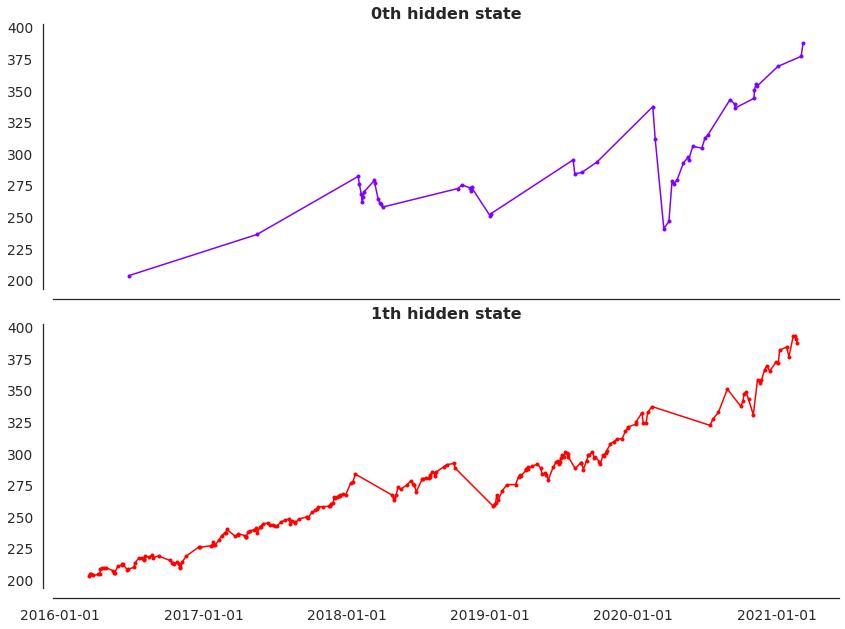

In [36]:
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(X_test.index.values[mask],
                 X_test["Close"].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()

findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


Text(0.5, 0.98, 'Historical SPY Regimes')

findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


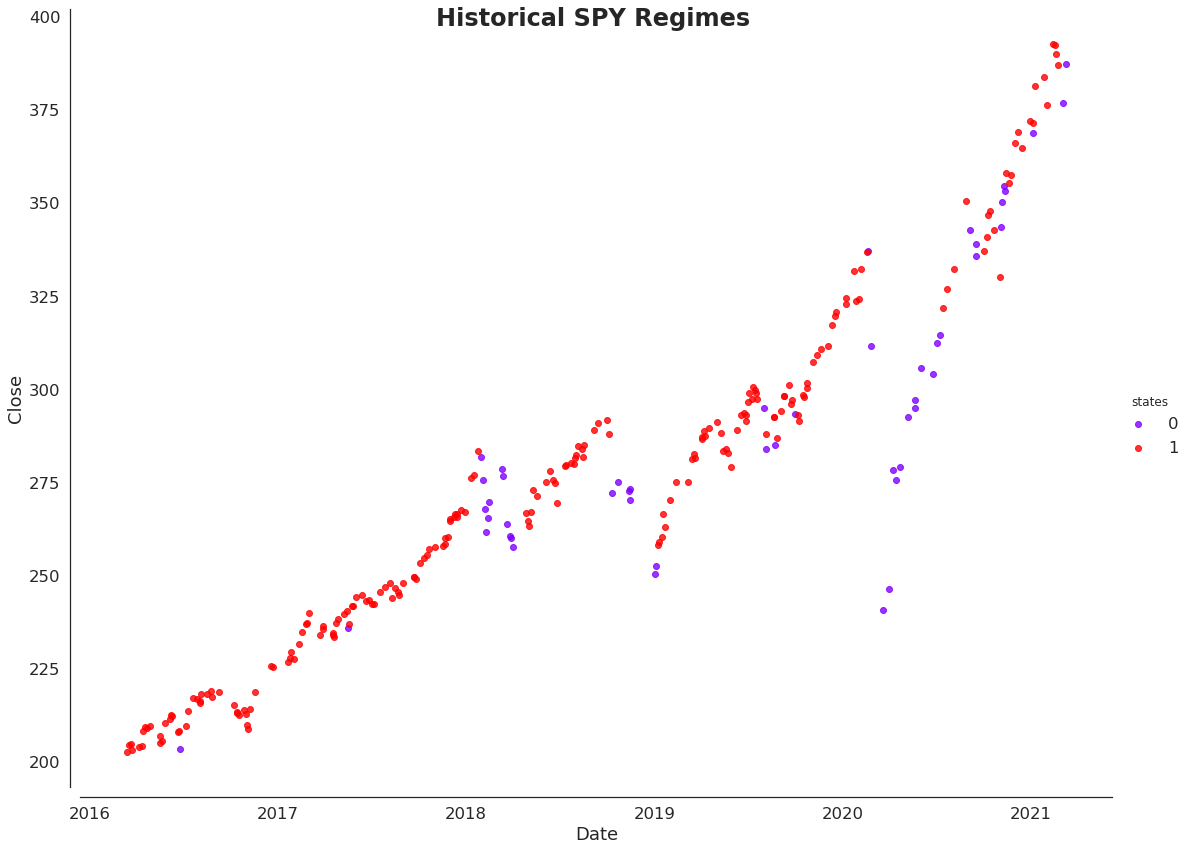

In [37]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=X_test.index)
          .join(X_test, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
states.head()

#suppressing warnings because of some issues with the font package
#in general, would not rec turning off warnings.
import warnings
warnings.filterwarnings("ignore")

sns.set_style('white', style_kwds)
order = [0, 1]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', "Close", alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SPY Regimes', fontsize=24, fontweight='demi')

Reference: 

Adapted from https://zerowithdot.com/hidden-markov-model/

https://towardsdatascience.com/

Market Regime Identification Using Hidden Markov Model